In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import keras as keras
from data_utils import read_files
from data_utils import *
import platform
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Using TensorFlow backend.


In [2]:
if platform.system() == 'Darwin':
    datafile_path = '/Users/anjalikarimpil/Google Drive/Dissertation/Data/Social LSTM/'
else:
    datafile_path = '/users/mscdsa2018/ask2/Projects/Data/Social LSTM'
# Get list of datafiles read
df_list, problem_list = read_files()


0
1


In [3]:
df = df_list[0].copy()
df['date'], df['time'] = df[0].str.split('T', 1).str
df[0] = pd.to_datetime(df[0], format="%Y-%m-%dT%H:%M:%S:%f")
df.columns = ['datetime', 'place', 'x_pos', 'y_pos', 'person_id', 'date', 'time']

In [4]:
df.sort_values(['person_id','datetime'], inplace=True, ascending=True)
df.reset_index()
df['time_lag'] = df.groupby(['person_id', 'date'])['datetime'].shift(1)
df['person_lag'] = df['person_id'].shift(1)


TIME_THRESHOLD = pd.to_timedelta('00:00:02.00000')
# flag 1 
df['fl_1'] = (abs(df['time_lag'] - df['datetime']) > TIME_THRESHOLD) | (df['person_lag'] != df['person_id'])
df['traj_id'] = df['fl_1'].cumsum()


In [5]:
POSITION_THRESHOLD = 500
df['x_lag'] = df.groupby(['traj_id'])['x_pos'].shift(1)
df['y_lag'] = df.groupby(['traj_id'])['y_pos'].shift(1)

df['x_diff'] = abs(df['x_pos'] - df['x_lag'])
df['y_diff'] = abs(df['y_pos'] - df['y_lag'])
df['fl_2'] = (df['x_diff'] > POSITION_THRESHOLD) | (df['y_diff'] > POSITION_THRESHOLD)
df['fl_3'] = (df['fl_1'] | df['fl_2'])
df['traj_id'] = df['fl_3'].cumsum()

In [7]:
df['x_lag'] = df.groupby(['traj_id'])['x_pos'].shift(1)
df['y_lag'] = df.groupby(['traj_id'])['y_pos'].shift(1)

df['x_diff'] = abs(df['x_pos'] - df['x_lag'])
df['y_diff'] = abs(df['y_pos'] - df['y_lag'])

df['x_diff'].describe()

count   4326044.00
mean         95.45
std          65.23
min           0.00
25%          41.00
50%         101.00
75%         132.00
max         500.00
Name: x_diff, dtype: float64

In [15]:
df.groupby(['traj_id']).agg({'x_diff': ['max'], 'y_diff': ['max']}).head(5)


,x_diff,y_diff
,max,max
traj_id,,
1,162.00,186.00
2,159.00,115.00
3,432.00,285.00
4,352.00,457.00
5,353.00,236.00


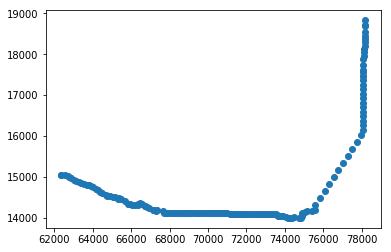

In [14]:
index = 6
df_1 = df.loc[df['traj_id'] == index]
plt.scatter(df_1['x_pos'], df_1['y_pos'])
plt.show()

In [32]:
data = df[['traj_id','x_pos','y_pos']].copy()
INPUT_SEQ_LENGTH = 5
OUTPUT_SEQ_LENGTH = 2
NUM_DIMENSIONS = 2
for i in range(1, INPUT_SEQ_LENGTH + OUTPUT_SEQ_LENGTH):
    data['x_' + str(i)] = data.groupby(['traj_id'])['x_pos'].shift(-i)
    data['y_' + str(i)] = data.groupby(['traj_id'])['y_pos'].shift(-i)
# Remove NAs 
data = data.dropna()

In [31]:
# data.iloc[:, -(OUTPUT_SEQ_LENGTH * NUM_DIMENSIONS):]
# data.iloc[:, 1:(INPUT_SEQ_LENGTH * NUM_DIMENSIONS)]

In [33]:
from sklearn.model_selection import train_test_split
def dataset_generator(data):
    train = 0.8
    test = 0.2
#     dev = 0.1
    total_length = len(data)
    total_trajectories = np.ma.count(data['traj_id'].unique())
    train_ix = train * total_trajectories
    test_ix = test * total_trajectories
    X = data.iloc[:, 1:(INPUT_SEQ_LENGTH * NUM_DIMENSIONS)]
    Y = data.iloc[:, -(OUTPUT_SEQ_LENGTH * NUM_DIMENSIONS):]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                        train_size = 0.8, test_size = 0.2, random_state = 1)
    return X_train, X_test, y_train, y_test
#     dev_ix = dev * total_trajectories


In [ ]:
X_train, X_test, y_train, y_test = dataset_generator(data)

In [1]:
# X_train, X_test, y_train, y_test = dataset_generator(data)
import data_utils
X_train, y_train, dev_X, dev_Y, X_test, y_test = data_utils.split_data()

In [35]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# X_train.reshape(shape = (-1, 10, 1 ))
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

(3457436, 40) (864359, 40) (3457436, 2) (864359, 2)


In [36]:
X_train = X_train.reshape((-1, 2, w) )
X_test = X_test.reshape((-1, 2, w) )

In [2]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
w = 5

(3460780, 2, 5) (432598, 2, 5) (3460780, 2) (432598, 2)


In [3]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
import numpy as np


print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(2, w)))
model.add(Dense(2))

# try using different optimizers and different optimizer configs
model.compile(loss='mae',
              optimizer='adam',
              metrics=['accuracy'])



/users/mscdsa2018/ask2/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Build model...


In [4]:

print('Train...')
history = model.fit(X_train,y_train,epochs=25, batch_size = 64, validation_data=(X_test, y_test))

model.save('my_model.h5')

score = model.evaluate(X_test, y_test, batch_size=64)
print(score)

print('Predicting')
# predicted_output = model.predict(test_input, batch_size=72)

Train...
Train on 3460780 samples, validate on 432598 samples
Epoch 1/25
3460780/3460780 [==============================] - 191s 55us/step - loss: 30860.3289 - acc: 0.2853 - val_loss: 29352.4973 - val_acc: 0.1689
Epoch 2/25
3460780/3460780 [==============================] - 191s 55us/step - loss: 27763.9874 - acc: 0.1691 - val_loss: 26368.1039 - val_acc: 0.1689
Epoch 3/25
3460780/3460780 [==============================] - 191s 55us/step - loss: 24728.7902 - acc: 0.2913 - val_loss: 23164.8745 - val_acc: 0.1692
Epoch 4/25
3460780/3460780 [==============================] - 190s 55us/step - loss: 21722.6004 - acc: 0.5221 - val_loss: 20697.6800 - val_acc: 0.8311
Epoch 5/25
3460780/3460780 [==============================] - 190s 55us/step - loss: 19459.2739 - acc: 0.8309 - val_loss: 18726.0717 - val_acc: 0.8311
Epoch 6/25
3460780/3460780 [==============================] - 190s 55us/step - loss: 18220.8393 - acc: 0.8309 - val_loss: 17700.7415 - val_acc: 0.8311
Epoch 7/25
3460780/3460780 [====

In [5]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 68,866
Trainable params: 68,866
Non-trainable params: 0
_________________________________________________________________
None


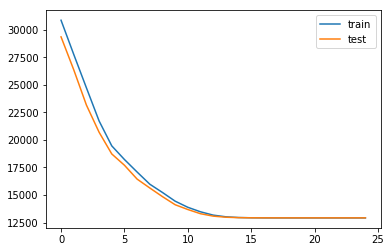

In [8]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [9]:
model.summary()
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 68,866
Trainable params: 68,866
Non-trainable params: 0
_________________________________________________________________
Inputs: (None, 2, 5)
Outputs: (None, 2)


In [43]:
model = keras.models.load_model('my_model.h5')

In [10]:
y_hat_test = model.predict(X_test)

In [11]:
y_hat_test.shape

(432598, 2)

In [12]:

dist = np.linalg.norm(y_hat_test-y_test, axis=1)

In [13]:

print(1/len(dist)*(np.sum(dist)))


22346.765945448784
